# Regression Duplication

Checking that I get the same results as the paper.

In equation **S3** the authors give the probability that an individual $i$ startels given that individual $j$ has startled as
$$
P(s_i | s_j) = \dfrac{1}{1+e^{-\beta_1-\beta_2 LMD - \beta_3 RAA}}
$$

- *LMD* is the log of the metric distance between the two fish
- *RAA* is the ranked angular area of fish $j$ (compared to other fish) on the retina of fish $i$.

Authors fit a logistic regression model to the entire dataset and find coefficients $beta_n$ $0.06449$, $−3.20552$, and $−0.08016$.

In [5]:
import pandas as pd
import numpy as np

# Read the CSV into dataframe
csv_path = "realdata/first_responders_srk1.csv"
df = pd.read_csv(csv_path)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14490 entries, 0 to 14489
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Trial             14490 non-null  object 
 1   Event_raw         14490 non-null  int64  
 2   Event_trial       14490 non-null  int64  
 3   Response          14490 non-null  int64  
 4   Resp_Int          14490 non-null  float64
 5   Initiator         14490 non-null  float64
 6   Log_Init          14490 non-null  float64
 7   When              14490 non-null  object 
 8   Class             14490 non-null  object 
 9   Dist_metric       14490 non-null  float64
 10  Log_dist_metric   14490 non-null  float64
 11  Dist_topological  14490 non-null  int64  
 12  Ang_area          14490 non-null  float64
 13  Rank_area         14490 non-null  int64  
 14  Loom              14490 non-null  float64
 15  Log_loom          14490 non-null  float64
 16  Ang_pos           14490 non-null  float6

This code block - written by Claude - attempts to recreate the coefficients the authors find in the last paragraph of Section 6.1.

There is a difference in the author's values compared to what I could find. I think that's due to the simplification of omitting the higher order terms in equation **S7**. But they say that for small cascades they are very small, so this works out.

In [6]:
# Fit the logistic regression model, to verify author's findings
# Targeting the PARAGRAPH values for first exposure (combining Before+After)
# Target: Intercept=0.06449, Log_dist_metric=-3.20552, Rank_area=-0.08016

import statsmodels.api as sm

print("=" * 80)
print("TARGETING PARAGRAPH VALUES FOR FIRST EXPOSURE")
print("=" * 80)
print("\nAuthors' reported coefficients (combining Before+After):")
print("  Intercept:        0.06449")
print("  Log_dist_metric: -3.20552")
print("  Rank_area:       -0.08016")

# Try different data filters to match author's approach
print("\n" + "=" * 80)
print("ATTEMPT 1: All data (Before + After, Schreck + Water)")
print("=" * 80)

X1 = df[["Log_dist_metric", "Rank_area"]]
y1 = df["Response"]
X1_const = sm.add_constant(X1)

logit1 = sm.Logit(y1, X1_const)
result1 = logit1.fit(disp=0)

print(f"Observations: {len(y1)}, Responses: {y1.sum()}")
print(f"  Intercept:        {result1.params['const']:>10.5f}")
print(f"  Log_dist_metric:  {result1.params['Log_dist_metric']:>10.5f}")
print(f"  Rank_area:        {result1.params['Rank_area']:>10.5f}")

# Try filtering for Schreckstoff only
print("\n" + "=" * 80)
print("ATTEMPT 2: Schreckstoff only (Before + After, Class=Schreck)")
print("=" * 80)

df_schreck = df[df["Class"] == "Schreck"].copy()
X2 = df_schreck[["Log_dist_metric", "Rank_area"]]
y2 = df_schreck["Response"]
X2_const = sm.add_constant(X2)

logit2 = sm.Logit(y2, X2_const)
result2 = logit2.fit(disp=0)

print(f"Observations: {len(y2)}, Responses: {y2.sum()}")
print(f"  Intercept:        {result2.params['const']:>10.5f}")
print(f"  Log_dist_metric:  {result2.params['Log_dist_metric']:>10.5f}")
print(f"  Rank_area:        {result2.params['Rank_area']:>10.5f}")

# Try Water control only
print("\n" + "=" * 80)
print("ATTEMPT 3: Water control only (Before + After, Class=Water)")
print("=" * 80)

df_water = df[df["Class"] == "Water"].copy()
X3 = df_water[["Log_dist_metric", "Rank_area"]]
y3 = df_water["Response"]
X3_const = sm.add_constant(X3)

logit3 = sm.Logit(y3, X3_const)
result3 = logit3.fit(disp=0)

print(f"Observations: {len(y3)}, Responses: {y3.sum()}")
print(f"  Intercept:        {result3.params['const']:>10.5f}")
print(f"  Log_dist_metric:  {result3.params['Log_dist_metric']:>10.5f}")
print(f"  Rank_area:        {result3.params['Rank_area']:>10.5f}")

# Try only After Schreckstoff
print("\n" + "=" * 80)
print("ATTEMPT 4: After Schreckstoff only (When=After, Class=Schreck)")
print("=" * 80)

df_after_schreck = df[(df["When"] == "After") & (df["Class"] == "Schreck")].copy()
X4 = df_after_schreck[["Log_dist_metric", "Rank_area"]]
y4 = df_after_schreck["Response"]
X4_const = sm.add_constant(X4)

logit4 = sm.Logit(y4, X4_const)
result4 = logit4.fit(disp=0)

print(f"Observations: {len(y4)}, Responses: {y4.sum()}")
print(f"  Intercept:        {result4.params['const']:>10.5f}")
print(f"  Log_dist_metric:  {result4.params['Log_dist_metric']:>10.5f}")
print(f"  Rank_area:        {result4.params['Rank_area']:>10.5f}")

# Try Before+After Water (baseline)
print("\n" + "=" * 80)
print("ATTEMPT 5: Before+After Water (baseline control)")
print("=" * 80)

df_water_both = df[df["Class"] == "Water"].copy()
X5 = df_water_both[["Log_dist_metric", "Rank_area"]]
y5 = df_water_both["Response"]
X5_const = sm.add_constant(X5)

logit5 = sm.Logit(y5, X5_const)
result5 = logit5.fit(disp=0)

print(f"Observations: {len(y5)}, Responses: {y5.sum()}")
print(f"  Intercept:        {result5.params['const']:>10.5f}")
print(f"  Log_dist_metric:  {result5.params['Log_dist_metric']:>10.5f}")
print(f"  Rank_area:        {result5.params['Rank_area']:>10.5f}")

# Summary comparison
print("\n" + "=" * 80)
print("SUMMARY COMPARISON")
print("=" * 80)

comparison = pd.DataFrame(
    {
        "Data Filter": [
            "Authors (Paragraph)",
            "All data",
            "Schreck only",
            "Water only",
            "After+Schreck",
            "Water (Before+After)",
        ],
        "Intercept": [
            0.06449,
            result1.params["const"],
            result2.params["const"],
            result3.params["const"],
            result4.params["const"],
            result5.params["const"],
        ],
        "Log_dist_metric": [
            -3.20552,
            result1.params["Log_dist_metric"],
            result2.params["Log_dist_metric"],
            result3.params["Log_dist_metric"],
            result4.params["Log_dist_metric"],
            result5.params["Log_dist_metric"],
        ],
        "Rank_area": [
            -0.08016,
            result1.params["Rank_area"],
            result2.params["Rank_area"],
            result3.params["Rank_area"],
            result4.params["Rank_area"],
            result5.params["Rank_area"],
        ],
    }
)

print("\n", comparison.to_string(index=False))

# Find closest match
diffs = []
for i in range(1, 6):
    diff = (
        abs(comparison.iloc[i]["Intercept"] - 0.06449)
        + abs(comparison.iloc[i]["Log_dist_metric"] - (-3.20552))
        + abs(comparison.iloc[i]["Rank_area"] - (-0.08016))
    )
    diffs.append(diff)

best_idx = diffs.index(min(diffs)) + 1
print(f"\n\nBest match: {comparison.iloc[best_idx]['Data Filter']}")
print(f"Total absolute difference: {min(diffs):.4f}")

TARGETING PARAGRAPH VALUES FOR FIRST EXPOSURE

Authors' reported coefficients (combining Before+After):
  Intercept:        0.06449
  Log_dist_metric: -3.20552
  Rank_area:       -0.08016

ATTEMPT 1: All data (Before + After, Schreck + Water)
Observations: 14490, Responses: 182
  Intercept:          -0.14380
  Log_dist_metric:    -2.91940
  Rank_area:          -0.09031

ATTEMPT 2: Schreckstoff only (Before + After, Class=Schreck)
Observations: 10725, Responses: 140
  Intercept:           0.10364
  Log_dist_metric:    -3.29782
  Rank_area:          -0.07503

ATTEMPT 3: Water control only (Before + After, Class=Water)
Observations: 3765, Responses: 42
  Intercept:          -1.16301
  Log_dist_metric:    -1.68831
  Rank_area:          -0.14234

ATTEMPT 4: After Schreckstoff only (When=After, Class=Schreck)
Observations: 8238, Responses: 112
  Intercept:           0.31921
  Log_dist_metric:    -3.63922
  Rank_area:          -0.06218

ATTEMPT 5: Before+After Water (baseline control)
Observa

Thus, I will use

- $\alpha_1 = 0.103641$
- $\alpha_2 = -3.297823$
- $\alpha_3 = -0.075034$

Plotting 140 Response=1 cases and 420 Response=0 cases
  (out of 10585 total Response=0 cases)


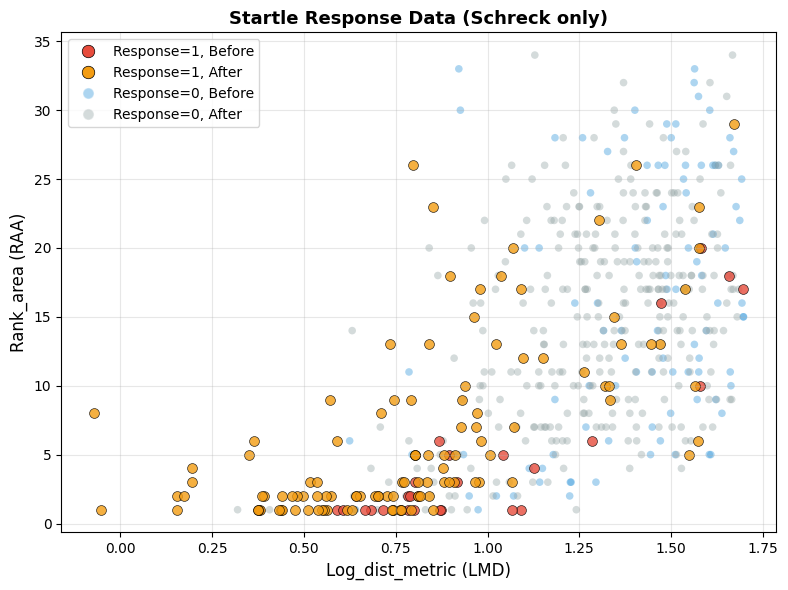

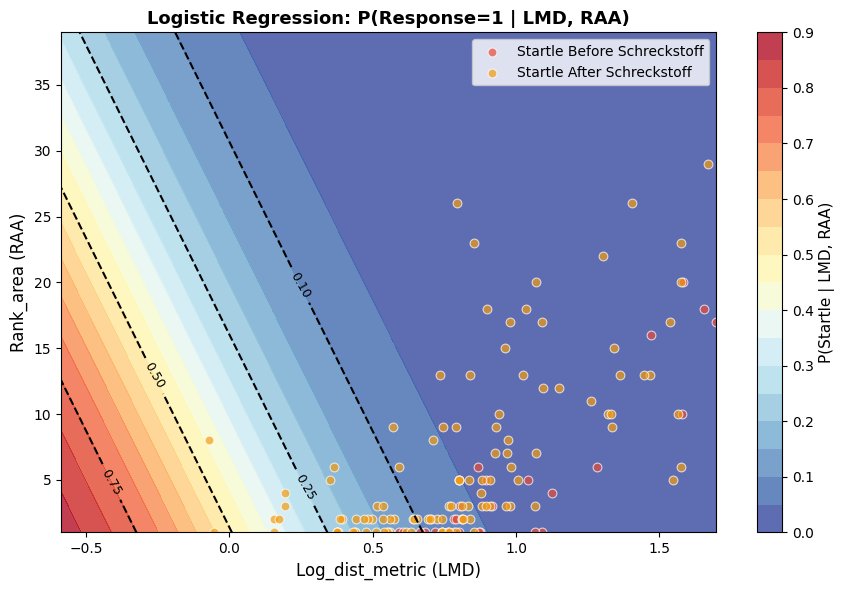


Model Coefficients (Schreck only):
  β₁ (Intercept):         0.103641
  β₂ (Log_dist_metric):  -3.297823
  β₃ (Rank_area):        -0.075034

Model equation:
  P(s_i | s_j) = 1 / (1 + exp(-β₁ - β₂·LMD - β₃·RAA))


In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Use the Schreck-only dataset (the selected model)
df_plot = df_schreck.copy()

# ============================================================================
# PLOT 1: Scatter plot of the data
# ============================================================================

# Separate Response=1 (rare) and Response=0 (common)
df_response1 = df_plot[df_plot["Response"] == 1]
df_response0 = df_plot[df_plot["Response"] == 0]

# Sample Response=0 to roughly 3x the Response=1 count for better visualization
n_response1 = len(df_response1)
n_sample0 = min(len(df_response0), n_response1 * 3)
df_response0_sample = df_response0.sample(n=n_sample0, random_state=42)

# Combine for plotting
df_viz = pd.concat([df_response1, df_response0_sample])

print(
    f"Plotting {len(df_response1)} Response=1 cases and {len(df_response0_sample)} Response=0 cases"
)
print(f"  (out of {len(df_response0)} total Response=0 cases)")

# Define four distinct colors for the four categories
colors = {
    (0, "Before"): "#3498db",  # Blue
    (0, "After"): "#95a5a6",  # Gray
    (1, "Before"): "#e74c3c",  # Red
    (1, "After"): "#f39c12",  # Orange
}

fig1, ax1 = plt.subplots(figsize=(8, 6))

# Plot all four combinations with unique colors
for response in [0, 1]:
    for when in ["Before", "After"]:
        subset = df_viz[(df_viz["Response"] == response) & (df_viz["When"] == when)]

        color = colors[(response, when)]
        alpha = 0.8 if response == 1 else 0.4
        size = 50 if response == 1 else 30

        ax1.scatter(
            subset["Log_dist_metric"],
            subset["Rank_area"],
            c=color,
            marker="o",
            s=size,
            alpha=alpha,
            edgecolors="black" if response == 1 else "none",
            linewidths=0.5 if response == 1 else 0,
            label=f"Response={response}, When={when}",
        )

ax1.set_xlabel("Log_dist_metric (LMD)", fontsize=12)
ax1.set_ylabel("Rank_area (RAA)", fontsize=12)
ax1.set_title("Startle Response Data (Schreck only)", fontsize=13, fontweight="bold")
ax1.grid(True, alpha=0.3)

# Legend
legend_elements = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=colors[(1, "Before")],
        markersize=9,
        label="Response=1, Before",
        markeredgecolor="black",
        markeredgewidth=0.5,
    ),
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=colors[(1, "After")],
        markersize=9,
        label="Response=1, After",
        markeredgecolor="black",
        markeredgewidth=0.5,
    ),
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=colors[(0, "Before")],
        markersize=8,
        label="Response=0, Before",
        alpha=0.4,
    ),
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=colors[(0, "After")],
        markersize=8,
        label="Response=0, After",
        alpha=0.4,
    ),
]
ax1.legend(handles=legend_elements, loc="best")

plt.tight_layout()
plt.show()

# ============================================================================
# PLOT 2: Regression model probability surface
# ============================================================================

# Create a mesh grid over the feature space
log_dist_range = np.linspace(
    df_plot["Log_dist_metric"].min(), df_plot["Log_dist_metric"].max(), 100
)
rank_area_range = np.linspace(
    df_plot["Rank_area"].min(), df_plot["Rank_area"].max(), 100
)
log_dist_mesh, rank_area_mesh = np.meshgrid(log_dist_range, rank_area_range)

# Get the fitted coefficients from result2 (Schreck only)
beta_1 = result2.params["const"]
beta_2 = result2.params["Log_dist_metric"]
beta_3 = result2.params["Rank_area"]

# Calculate probability surface: P = 1 / (1 + exp(-beta_1 - beta_2*LMD - beta_3*RAA))
logit = beta_1 + beta_2 * log_dist_mesh + beta_3 * rank_area_mesh
prob_mesh = 1 / (1 + np.exp(-logit))

fig2, ax2 = plt.subplots(figsize=(9, 6))

# Create contour plot
contour = ax2.contourf(
    log_dist_mesh, rank_area_mesh, prob_mesh, levels=20, cmap="RdYlBu_r", alpha=0.8
)
contour_lines = ax2.contour(
    log_dist_mesh,
    rank_area_mesh,
    prob_mesh,
    levels=[0.1, 0.25, 0.5, 0.75, 0.9],
    colors="black",
    linewidths=1.5,
    linestyles="--",
)
ax2.clabel(contour_lines, inline=True, fontsize=9, fmt="%.2f")

# Overlay actual Response=1 data points
response1_before = df_response1[df_response1["When"] == "Before"]
response1_after = df_response1[df_response1["When"] == "After"]
ax2.scatter(
    response1_before["Log_dist_metric"],
    response1_before["Rank_area"],
    c=colors[(1, "Before")],
    marker="o",
    s=40,
    alpha=0.7,
    edgecolors="white",
    linewidths=0.8,
    label="Startle Before Schreckstoff",
)
ax2.scatter(
    response1_after["Log_dist_metric"],
    response1_after["Rank_area"],
    c=colors[(1, "After")],
    marker="o",
    s=40,
    alpha=0.7,
    edgecolors="white",
    linewidths=0.8,
    label="Startle After Schreckstoff",
)

ax2.set_xlabel("Log_dist_metric (LMD)", fontsize=12)
ax2.set_ylabel("Rank_area (RAA)", fontsize=12)
ax2.set_title(
    "Logistic Regression: P(Response=1 | LMD, RAA)", fontsize=13, fontweight="bold"
)
ax2.legend(loc="best")

# Add colorbar
cbar = plt.colorbar(contour, ax=ax2)
cbar.set_label("P(Startle | LMD, RAA)", fontsize=11)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("Model Coefficients (Schreck only):")
print("=" * 80)
print(f"  β₁ (Intercept):       {beta_1:>10.6f}")
print(f"  β₂ (Log_dist_metric): {beta_2:>10.6f}")
print(f"  β₃ (Rank_area):       {beta_3:>10.6f}")
print("\nModel equation:")
print("  P(s_i | s_j) = 1 / (1 + exp(-β₁ - β₂·LMD - β₃·RAA))")

In [8]:
# Define Couzin zone parameters based on empirical NND data
# Fish body size: ~3 cm diameter (5.5 cm long golden shiner)

# SCARED/TIGHT FORMATION (observed NND ≈ 4.24 cm)
# Fish swim closely together, tolerating near-collision proximity
SCARED_ZONES = {
    "zone_repulsion": 2.0,  # cm - just above collision threshold (0.67× body length)
    "zone_orientation": 8.0,  # cm - 4× repulsion zone
    "zone_attraction": 16.0,  # cm - 8× repulsion zone
}

# RELAXED/LOOSE FORMATION (observed NND ≈ 6.24 cm)
# Fish maintain comfortable personal space
RELAXED_ZONES = {
    "zone_repulsion": 4.5,  # cm - larger personal space (1.5× body length)
    "zone_orientation": 18.0,  # cm - 4× repulsion zone
    "zone_attraction": 36.0,  # cm - 8× repulsion zone
}

# DEFAULT/BASELINE FORMATION (original model)
DEFAULT_ZONES = {
    "zone_repulsion": 3.0,  # cm
    "zone_orientation": 12.0,  # cm
    "zone_attraction": 24.0,  # cm
}

print("=" * 70)
print("COUZIN MODEL ZONE PARAMETERS")
print("=" * 70)
print(f"\n{'Parameter':<20} {'Scared/Tight':<15} {'Default':<15} {'Relaxed/Loose':<15}")
print("-" * 70)
print(
    f"{'zone_repulsion':<20} {SCARED_ZONES['zone_repulsion']:<15.1f} {DEFAULT_ZONES['zone_repulsion']:<15.1f} {RELAXED_ZONES['zone_repulsion']:<15.1f}"
)
print(
    f"{'zone_orientation':<20} {SCARED_ZONES['zone_orientation']:<15.1f} {DEFAULT_ZONES['zone_orientation']:<15.1f} {RELAXED_ZONES['zone_orientation']:<15.1f}"
)
print(
    f"{'zone_attraction':<20} {SCARED_ZONES['zone_attraction']:<15.1f} {DEFAULT_ZONES['zone_attraction']:<15.1f} {RELAXED_ZONES['zone_attraction']:<15.1f}"
)
print("\n" + "=" * 70)

print("\nExpected NND (≈ zone_repulsion + buffer):")
print(f"  Scared state:  ~{SCARED_ZONES['zone_repulsion'] + 2:.1f} cm")
print(f"  Default state: ~{DEFAULT_ZONES['zone_repulsion'] + 2:.1f} cm")
print(f"  Relaxed state: ~{RELAXED_ZONES['zone_repulsion'] + 2:.1f} cm")

print("\nComparison to empirical data:")
print(f"  Empirical scared NND:  {schreck_mean_nnd:.2f} cm")
print(f"  Empirical relaxed NND: {water_mean_nnd:.2f} cm")

print("\n" + "=" * 70)
print("USAGE EXAMPLE:")
print("=" * 70)
print(
    """
# Run simulation with scared (tight) formation
from fish_school_simulator import run_simulation

school_scared = run_simulation(
    n_fish=50,
    n_steps=500,
    gamma=10,
    delta=20,
    zone_repulsion=SCARED_ZONES['zone_repulsion'],
    zone_orientation=SCARED_ZONES['zone_orientation'],
    zone_attraction=SCARED_ZONES['zone_attraction'],
    verbose=False
)

# Run simulation with relaxed (loose) formation
school_relaxed = run_simulation(
    n_fish=50,
    n_steps=500,
    gamma=10,
    delta=20,
    zone_repulsion=RELAXED_ZONES['zone_repulsion'],
    zone_orientation=RELAXED_ZONES['zone_orientation'],
    zone_attraction=RELAXED_ZONES['zone_attraction'],
    verbose=False
)
"""
)
print("=" * 70)

COUZIN MODEL ZONE PARAMETERS

Parameter            Scared/Tight    Default         Relaxed/Loose  
----------------------------------------------------------------------
zone_repulsion       2.0             3.0             4.5            
zone_orientation     8.0             12.0            18.0           
zone_attraction      16.0            24.0            36.0           


Expected NND (≈ zone_repulsion + buffer):
  Scared state:  ~4.0 cm
  Default state: ~5.0 cm
  Relaxed state: ~6.5 cm

Comparison to empirical data:


NameError: name 'schreck_mean_nnd' is not defined

## Couzin Model Zone Parameters from NND Data

Based on the empirical NND measurements above, we can define appropriate zone parameters for the Couzin model to simulate scared (tight) vs relaxed (loose) fish formations.

**Key Insight**: Fish swimming in scared state maintain NND ≈ 4.24 cm, while relaxed fish maintain NND ≈ 6.24 cm. The zone_repulsion parameter should be smaller than the observed NND, allowing fish to maintain their natural spacing.

In [32]:
import h5py
import numpy as np

# Load empirical nearest neighbor distance (NND) data
with h5py.File("realdata/NND_data.h5", "r") as f:
    schreck_data = f["schreck_1st"][:]  # Schreckstoff (alarm hormone) - scared state
    water_data = f["water_1st"][:]  # Water control - relaxed state

# Replace any zero with NaN
schreck_nnd = np.where(schreck_data == 0, np.nan, schreck_data)
water_nnd = np.where(water_data == 0, np.nan, water_data)

# Get median distance of all fish in all frames of all trials, ignoring NaN
schreck_median_nnd = np.nanmedian(schreck_nnd[2000:2500, :, :])
water_median_nnd = np.nanmedian(water_nnd[2000:2500, :, :])
print(f"Median Schreckstoff nearest neighbor distance: {schreck_median_nnd:.2f} cm")
print(f"Median water nearest neighbor distance: {water_median_nnd:.2f} cm")

print(f"\nComparison:")
print(f"  Ratio (relaxed/scared): {water_median_nnd/schreck_median_nnd:.2f}x")
print(f"  Scared fish swim {(1 - schreck_median_nnd/water_median_nnd)*100:.1f}% closer")
print(
    f"  Relaxed fish swim {(water_median_nnd/schreck_median_nnd - 1)*100:.1f}% farther apart"
)

Median Schreckstoff nearest neighbor distance: 3.54 cm
Median water nearest neighbor distance: 6.01 cm

Comparison:
  Ratio (relaxed/scared): 1.70x
  Scared fish swim 41.2% closer
  Relaxed fish swim 70.0% farther apart


1260


/var/folders/7m/pkkbqhrj14gbpp0s_zb7v9k40000gn/T/ipykernel_91862/2252382312.py:1: RuntimeWarning: All-NaN slice encountered
  vector = np.nanmedian(water_nnd, axis=(1,2))


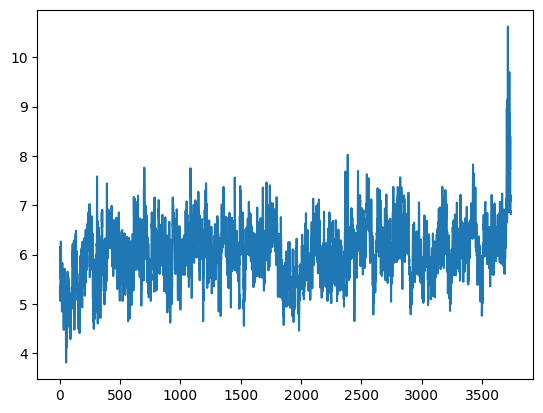

In [31]:
vector = np.nanmedian(water_nnd, axis=(1, 2))
print(np.count_nonzero(np.isnan(vector)))

mask = ~np.isnan(vector)
plt.plot(np.arange(len(vector))[mask], vector[mask])
plt.show()

In [ ]:
# Convert median distances to Couzin parameters

## Fitting Couzin Zone Parameters to Target NND Values

We want to find the right `zone_repulsion` and `zone_attraction` parameters to match empirical nearest neighbor distances (NND):
- **Relaxed state (water control)**: Target NND ≈ 6.0 cm
- **Alarmed state (schreckstoff)**: Target NND ≈ 3.5 cm

We'll test different parameter combinations by running simulations without predators and measuring the steady-state NND at frame 400.

In [ ]:
import sys

sys.path.insert(0, "..")  # Add parent directory to path
from fish_school_simulator import run_simulation
import numpy as np

# Target NND values from empirical data
TARGET_RELAXED_NND = 6.0  # cm (water control)
TARGET_ALARMED_NND = 3.5  # cm (schreckstoff)

# Parameter sets to test
# Note: zone_orientation and zone_attraction maintain 4x and 8x ratios relative to zone_repulsion
test_configs = [
    # Relaxed state tests (target NND = 6.0 cm)
    # {
    #     "name": "Relaxed: repulsion=4.5, attraction=24",
    #     "zone_repulsion": 4.5,
    #     "zone_orientation": 18.0,
    #     "zone_attraction": 24.0,
    #     "target_nnd": TARGET_RELAXED_NND,
    #     "state": "relaxed",
    # },
    {
        "name": "Relaxed: repulsion=5, orientation=12, attraction=36",
        "zone_repulsion": 5.0,
        "zone_orientation": 12.0,
        "zone_attraction": 36.0,
        "target_nnd": TARGET_RELAXED_NND,
        "state": "relaxed",
    },
    # Alarmed state tests (target NND = 3.5 cm)
    # {
    #     "name": "Alarmed: repulsion=3, attraction=48",
    #     "zone_repulsion": 3,
    #     "zone_orientation": 12.0,
    #     "zone_attraction": 48.0,
    #     "target_nnd": TARGET_ALARMED_NND,
    #     "state": "alarmed",
    # },
    {
        "name": "Alarmed: repulsion=2.75, orientation=12, attraction=48",
        "zone_repulsion": 2.75,
        "zone_orientation": 12.0,
        "zone_attraction": 48.0,
        "target_nnd": TARGET_ALARMED_NND,
        "state": "alarmed",
    },
]

print("=" * 80)
print("TESTING COUZIN ZONE PARAMETERS FOR TARGET NND VALUES")
print("=" * 80)
print(f"\nTarget NND - Relaxed state (water): {TARGET_RELAXED_NND:.2f} cm")
print(f"Target NND - Alarmed state (schreck): {TARGET_ALARMED_NND:.2f} cm")
print(f"\nRunning 10 simulations per configuration...")
print("Each simulation: 40 fish, 400 frames, NO predator\n")

results = []

for config in test_configs:
    print("\n" + "=" * 80)
    print(f"Testing: {config['name']}")
    print("=" * 80)
    print(f"  zone_repulsion:   {config['zone_repulsion']:.1f} cm")
    print(f"  zone_orientation: {config['zone_orientation']:.1f} cm")
    print(f"  zone_attraction:  {config['zone_attraction']:.1f} cm")
    print(f"  Target NND:       {config['target_nnd']:.2f} cm")

    nnd_values = []

    # Run 10 simulations
    for trial in range(10):
        # Run simulation without predator (set spawn frame beyond simulation length)
        school = run_simulation(
            n_fish=40,
            n_steps=400,
            predator_spawn_frame=9999,  # Never spawn predator
            gamma=10,
            delta=20,
            space_size=(100, 200, 100),  # Tank dimensions
            zone_repulsion=config["zone_repulsion"],
            zone_orientation=config["zone_orientation"],
            zone_attraction=config["zone_attraction"],
            verbose=False,
        )

        # Calculate average NND at frame 400
        avg_nnd = school.get_average_nearest_neighbor_distance()
        nnd_values.append(avg_nnd)

        if trial % 2 == 1:  # Print progress every 2 trials
            print(f"  Trial {trial+1}/10: NND = {avg_nnd:.2f} cm")

    # Calculate statistics
    mean_nnd = np.mean(nnd_values)
    std_nnd = np.std(nnd_values)
    min_nnd = np.min(nnd_values)
    max_nnd = np.max(nnd_values)
    error = abs(mean_nnd - config["target_nnd"])

    results.append(
        {
            "config": config["name"],
            "state": config["state"],
            "zone_repulsion": config["zone_repulsion"],
            "zone_attraction": config["zone_attraction"],
            "target_nnd": config["target_nnd"],
            "mean_nnd": mean_nnd,
            "std_nnd": std_nnd,
            "min_nnd": min_nnd,
            "max_nnd": max_nnd,
            "error": error,
            "nnd_values": nnd_values,
        }
    )

    print(f"\n  Results (10 trials):")
    print(f"    Mean NND:   {mean_nnd:.2f} ± {std_nnd:.2f} cm")
    print(f"    Range:      [{min_nnd:.2f}, {max_nnd:.2f}] cm")
    print(f"    Target:     {config['target_nnd']:.2f} cm")
    print(f"    Error:      {error:.2f} cm ({error/config['target_nnd']*100:.1f}%)")

# Summary table
print("\n\n" + "=" * 80)
print("SUMMARY - All Configurations")
print("=" * 80)
print(
    f"{'Configuration':<40} {'Mean NND':<12} {'Target':<10} {'Error':<10} {'Error %':<10}"
)
print("-" * 80)

for r in results:
    error_pct = r["error"] / r["target_nnd"] * 100
    print(
        f"{r['config']:<40} {r['mean_nnd']:>6.2f} ± {r['std_nnd']:<4.2f} {r['target_nnd']:>6.2f}    {r['error']:>6.2f}    {error_pct:>6.1f}%"
    )

print("=" * 80)

# Find best configuration for each state
relaxed_results = [r for r in results if r["state"] == "relaxed"]
alarmed_results = [r for r in results if r["state"] == "alarmed"]

if relaxed_results:
    best_relaxed = min(relaxed_results, key=lambda x: x["error"])
    print(f"\nBest for RELAXED state: {best_relaxed['config']}")
    print(
        f"  Mean NND: {best_relaxed['mean_nnd']:.2f} cm (target: {best_relaxed['target_nnd']:.2f} cm)"
    )
    print(
        f"  Parameters: repulsion={best_relaxed['zone_repulsion']}, attraction={best_relaxed['zone_attraction']}"
    )

if alarmed_results:
    best_alarmed = min(alarmed_results, key=lambda x: x["error"])
    print(f"\nBest for ALARMED state: {best_alarmed['config']}")
    print(
        f"  Mean NND: {best_alarmed['mean_nnd']:.2f} cm (target: {best_alarmed['target_nnd']:.2f} cm)"
    )
    print(
        f"  Parameters: repulsion={best_alarmed['zone_repulsion']}, attraction={best_alarmed['zone_attraction']}"
    )

TESTING COUZIN ZONE PARAMETERS FOR TARGET NND VALUES

Target NND - Relaxed state (water): 6.00 cm
Target NND - Alarmed state (schreck): 3.50 cm

Running 10 simulations per configuration...
Each simulation: 40 fish, 400 frames, NO predator


Testing: Relaxed: repulsion=4.6, attraction=36
  zone_repulsion:   5.0 cm
  zone_orientation: 12.0 cm
  zone_attraction:  36.0 cm
  Target NND:       6.00 cm
  Trial 2/10: NND = 8.16 cm
  Trial 4/10: NND = 5.84 cm
  Trial 6/10: NND = 6.04 cm
  Trial 8/10: NND = 5.45 cm
  Trial 10/10: NND = 5.00 cm

  Results (10 trials):
    Mean NND:   6.07 ± 0.81 cm
    Range:      [5.00, 8.16] cm
    Target:     6.00 cm
    Error:      0.07 cm (1.1%)

Testing: Alarmed: repulsion=3, attraction=48
  zone_repulsion:   2.8 cm
  zone_orientation: 12.0 cm
  zone_attraction:  48.0 cm
  Target NND:       3.50 cm
  Trial 2/10: NND = 3.72 cm
  Trial 4/10: NND = 3.48 cm
  Trial 6/10: NND = 3.49 cm
  Trial 8/10: NND = 2.95 cm
  Trial 10/10: NND = 3.13 cm

  Results (10 trial

### Understanding the Relationship Between Zone Parameters and NND

**Key Insight**: The `zone_repulsion` parameter sets the **minimum tolerable distance** between fish, not the target NND.

- When two fish are closer than `zone_repulsion`, they actively move **away** from each other
- The average NND settles at a distance **slightly larger** than `zone_repulsion` in equilibrium
- Setting `zone_repulsion = 6.0` would result in NND **> 6.0 cm**, not equal to it

**Parameter Guidelines**:
- For **relaxed state** (target NND ≈ 6.0 cm): Try `zone_repulsion ≈ 4.5-5.0 cm`  
- For **alarmed state** (target NND ≈ 3.5 cm): Try `zone_repulsion ≈ 2.5-3.0 cm`

The `zone_attraction` parameter controls how tightly the school coheres. A larger attraction zone keeps fish closer together on average, which can reduce NND.

## Empirical Nearest Neighbor Distances: Scared vs Relaxed States

The `NND_data.h5` file contains nearest neighbor distance measurements for fish under two conditions:
- **Schreck (scared)**: Fish exposed to schreckstoff (alarm hormone) - tight formation
- **Water (relaxed)**: Water control - loose formation

These measurements inform the Couzin model zone parameters for simulating scared vs relaxed schooling behavior.